In [1]:
from pathlib import Path
from smokingml.datasets.nursing_dataset_v1 import nursing_dataset_v1, nursingv1_train_dev_test_split, utils, WINSIZE
from smokingml.modules import evaluate_loop, train_loop, inner_evaluate_loop, inner_train_loop, optimization_loop
from smokingml.models import mlp_1hl, FCN, CNN
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
from smokingml.utils import plot_and_save_cm
from tqdm import tqdm

/home/mmazeem/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nursingv1_dir = Path('../data/nursingv1_dataset')
session_ids = utils.get_all_session_ids(nursingv1_dir)[:10]
train_dataset, dev_dataset, _ = nursingv1_train_dev_test_split(
    nursingv1_dir,
    train_size=1-0.5,
    dev_size=0.5,
    test_size=0.0,
    shuffle=True,
    session_ids=session_ids
)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
devloader = DataLoader(dev_dataset, batch_size=64, shuffle=True)

In [3]:
device = 'cuda:0'
model = FCN(3, WINSIZE).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

100%|██████████| 2/2 [01:23<00:00, 42.00s/it]


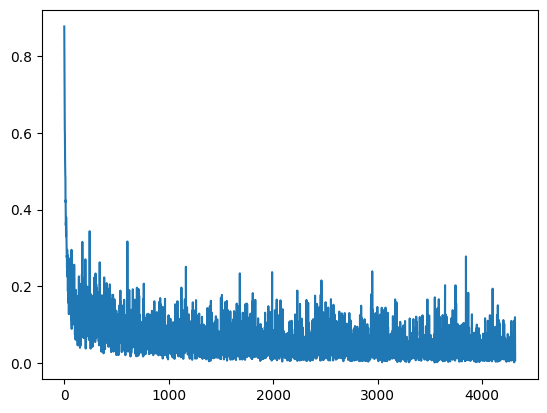

In [6]:
lossi = []
for i in tqdm(range(2)):
    lossi += inner_train_loop(model, trainloader, criterion, optimizer, device)
plt.plot(lossi)

In [ ]:
train_loop(model, trainloader, criterion, optimizer, epochs=5, device=device)

In [7]:
y_true, y_pred, loss = evaluate_loop(model, criterion, trainloader, device)
plot_and_save_cm(y_true, y_pred, 'cm.jpg')
loss

Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 13.978


0.030307602547060036

In [8]:
y_true, y_pred, loss = evaluate_loop(model, criterion, devloader, device)
plot_and_save_cm(y_true, y_pred, 'cm.jpg')
loss

Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 17.764


0.2309973568296554

In [ ]:
dev_dataset.session_ids

In [14]:
session = dev_dataset.load_one_windowed_session(60)

one_guyloader = DataLoader(session, batch_size=64)

y_true, y_pred, loss = evaluate_loop(model, criterion, one_guyloader, device)
plot_and_save_cm(y_true.flatten(), y_pred.flatten(), 'cm.jpg')

Starting evaluate_loop
Finished evaluate_loop. Elapsed time: 2.799


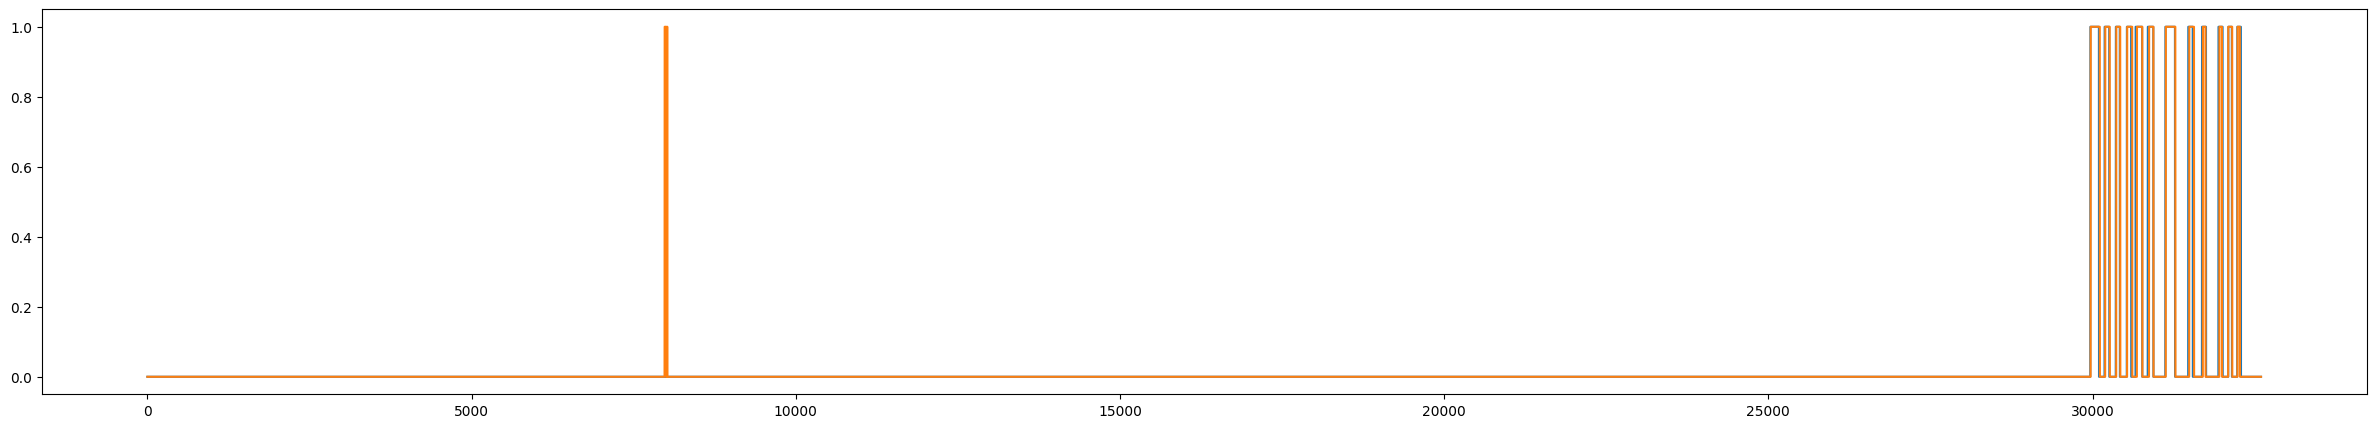

In [16]:
plt.figure(figsize=(30,5))
plt.plot(y_true)
plt.plot(y_pred)
plt.savefig('out.pdf')